# In case we need to pipeline their dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing dependencies and importing files

In [ ]:
#!pip install PyPDF2
#!pip install pyspark
#!pip install PyMuPDF


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 22.6 MB/s eta 0:00:00


In [ ]:
import PyPDF2 as pdf
import fitz  # PyMuPDF
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import col
from pyspark.sql.functions import desc
from pyspark.sql.types import StructType, StructField, StringType
import os


In [ ]:
spark = SparkSession.builder.appName("PDF Text Processing").getOrCreate()
sc = spark.sparkContext

Data Processing

In [ ]:
# Specify the path to your PDF file(s)
pdf_path = "/content/drive/MyDrive/Big Data Anonymization/Provista Files/Auto-Populated Report.pdf"

# Function to process a single PDF and extract data
def process_pdf(pdf_path):
    data = []
    with open(pdf_path, 'rb') as file:
        pdf_reader = pdf.PdfReader(file)

        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            text = page.extract_text()

            if text:  # If text extraction is successful
                split_text = text.split("\n")
                try:
                    patient_row = Row(Barcode=split_text[0], PatientID=split_text[3], Ethnicity=split_text[6],
                                      Age=split_text[7], SerumTumorMarkers=split_text[12], ClinicallySignificant=split_text[27],
                                      PiRAD=split_text[28], MRIDate=split_text[19], Location=split_text[34],
                                      TumorMarkersResults=split_text[22], Conclusion=split_text[25])
                    data.append(patient_row)
                except IndexError:  # Handle cases where some data might not be available
                    print(f"Error processing page {page_num}: Text structure not as expected.")
    return data

# Process the PDF and create a Spark DataFrame from the data
data = process_pdf(pdf_path)
df = spark.createDataFrame(data)

# Show the DataFrame to verify the results
df.show()


+------------+------------+---------+---+--------------------+---------------------+---------+-----------+--------------------+--------------------+--------------------+
|     Barcode|   PatientID|Ethnicity|Age|   SerumTumorMarkers|ClinicallySignificant|    PiRAD|    MRIDate|            Location| TumorMarkersResults|          Conclusion|
+------------+------------+---------+---+--------------------+---------------------+---------+-----------+--------------------+--------------------+--------------------+
|000000000318| PRO00000061|    Other| 61|Total PSA (ng/mL)...| Yes Clinically Si...|PI-RAD: 3| 19-11-2017|Location: 123 Map...|Some Tumor Marker...|WE SUGGEST TO DIS...|
+------------+------------+---------+---+--------------------+---------------------+---------+-----------+--------------------+--------------------+--------------------+



# **Anonymization**


Anonymization using the open-source presidio library. Presidio makes use of nlp-models (transformers), pattern-recognition, context and more to perform anonymization of data.

In [ ]:
from presidio_analyzer import (Pattern,PatternRecognizer,RecognizerRegistry,AnalyzerEngine,)
from presidio_analyzer.predefined_recognizers import *
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities import OperatorConfig, RecognizerResult

## Define custom patterns

In [ ]:
# Create a weak ID regex (matches any string of numbers greater than length 8 and less than 20)
generic_id_regex = r"\b\d{9,20}\b"
generic_id_pattern = Pattern(name='generic id (weak)', regex=generic_id_regex, score=0.1)

# Define a recognizer using the generic_id pattern
general_id_recognizer_w_context = PatternRecognizer(
    supported_entity = "GENERIC_ID",
    patterns = [generic_id_pattern],
    context = ["id", "identification", "license"]
)

## Define Analyzer

### Initialize recognizer registry

In [ ]:
# Initialize a new registry, used to load recognizers used for anonymization
registry = RecognizerRegistry()

# Add custom recognizers
registry.add_recognizer(general_id_recognizer_w_context)

# Add the predefined_recognizers that will be used in the anonymization process
recognizers_list = [
    CreditCardRecognizer,
    DateRecognizer,
    EmailRecognizer,
    MedicalLicenseRecognizer,
    PhoneRecognizer,
    UrlRecognizer,
    IbanRecognizer,
]

for recognizer in recognizers_list:
    registry.add_recognizer(recognizer(supported_language='en'))

# Special Case Transformers Recognizer : Recognize entities using the spacy-huggingface-pipeline package.
# PERSON, LOCATION, ORGANIZATION, AGE, ID, EMAIL, DATE_TIME, NUMBER. Perform context enchancement
registry.add_recognizer(TransformersRecognizer(supported_language='en', context=['patient']))

### Create analyzer

In [ ]:
analyzer = AnalyzerEngine(registry=registry)

## Define Anonymizer

In [ ]:
# Define two anonymizers, one that strips the anonymized data completely and another that replaces it with the entity tag
# Define anonymization operators
redact_operator = {
    "DEFAULT": OperatorConfig("redact", {}),
}

# Setting the entity operator to None results in the anonymizer using the entity names for anonymization
entity_operator = None
anonymizer = AnonymizerEngine()

In [ ]:
# Function called to anonymize the data using the initialized anonymizer
def anonymize(unmasked_text,analyzer,anonymizer, operator):
    analyzer_results = analyzer.analyze(text=unmasked_text, language="en")
    anonymized_results = anonymizer.anonymize(
        text=unmasked_text, analyzer_results=analyzer_results, operators=operator
    )
    return anonymized_results

# **spaCy**

This Named-Entity-Recognition model is built by fine-tuning the core small model (sm)
The training dataset is taken from https://huggingface.co/datasets/ai4privacy/pii-masking-200k
The first step involves transforming the data into a format spaCy can recognize. For example: ("Tokyo Tower is 333m tall.", [(0, 11, "BUILDING")]). Where a dictionary with text followed by a tupple that includes start, end, and label of the interesting named entities.

In [ ]:
#Data preparation for NER using spaCy
# pip install datasets spacy
# pip install spacy
# python -m spacy download en_core_web_sm

from datasets import load_dataset
import ast

# Load the dataset
dataset = load_dataset("ai4privacy/pii-masking-200k", split="train")

# Function to convert dataset entries to spaCy's training data format
def convert_to_spacy_format(example):
    text = example["unmasked_text"]
    labels = example["span_labels"]

    if isinstance(labels, str):   # Convert string to list as the dataset is in string format
        try:
            labels = ast.literal_eval(labels)
        except ValueError:
            print("Skipping irregular label_info:", labels)
            return (text, {"entities": []})

    entities = []
    for start, end, label in labels:
        if label != 'O':
            entities.append((start, end, label))

    return (text, {"entities": entities})

spacy_training_data = [convert_to_spacy_format(dataset[i]) for i in range(2)]  # Adjust as needed
print(spacy_training_data)


Once the data is prepared, it can be used to fine-tune the existing NER sm model. This will create a train.spacy file, which is where the fine-tuned model is.

In [ ]:
import spacy
from spacytest import spacy_training_data, convert_to_spacy_format
from spacy.util import minibatch, compounding
import random
from datasets import load_dataset
import ast
from spacy.training import Example
from spacy.scorer import Scorer


random.seed(1)


nlp = spacy.load("en_core_web_sm")
dataset = load_dataset("ai4privacy/pii-masking-200k", split="train")
spacy_training_data = [convert_to_spacy_format(dataset[i]) for i in range(100)]  #determine the training dataset size here

# Convert the training data to Example objects
def make_examples(nlp, data):
    examples = []
    for text, annotations in data:
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, annotations)
        examples.append(example)
    return examples

# Convert  training data to Example objects
examples = make_examples(nlp, spacy_training_data)

# Add labels to the NER pipeline / fine-tuning
if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
else:
    ner = nlp.get_pipe("ner")
# Add new entity labels to NER
for _, annotations in spacy_training_data:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

# Disable other pipeline components during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]


with nlp.disable_pipes(*other_pipes):  # Only train NER
    optimizer = nlp.resume_training()
    for itn in range(10):  # Number of training iterations
        random.shuffle(examples)
        losses = {}

        # Batch up the examples using spaCy's minibatch
        batches = minibatch(examples, size=compounding(4., 32., 1.001))
        for batch in batches:
            nlp.update(
                batch,  # batch of Example objects
                drop=0.5,  # dropout - make it harder to memorize data
                sgd=optimizer,  # callable to update weights
                losses=losses)
        print("Losses", losses)

# Save the model to disk
nlp.to_disk("./SpacyNER")

# **Fine-tuning distillBERT**


The final model to try will be to fine-tune an existant one, but to serve our process. To do so, we will fine-tune distillBERT. DistillBERT is a smaller version of BERT, a model built for a multitude of tasks; but namely the one used in this project; Named-Entity Recognition. \

What is being done in this part of the project is adding a layer to the underlying architecture of BERT. In other words, adding a classification layer so our model can tag the words in the sentence, and learn to recognize the proper tags.

The following code is adapted from huggingface's tutorial on fine-tuning a token classification model found here:

https://huggingface.co/docs/transformers/en/tasks/token_classification


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install transformers datasets evaluate seqeval
!pip install transformers[torch] -U
!pip install accelerate -U

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForTokenClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import load_dataset
from transformers import DataCollatorForTokenClassification
from datasets import DatasetDict
import evaluate
import torch
import numpy as np

Loading the dataset and filtering to keep only necessary columns.

In [ ]:
dataset = load_dataset("ai4privacy/pii-masking-200k", split = 'train[:1%]') #take 50% of the dataset since training time too long just for model testing

# Dropping columns that won't be used
dataset = dataset.remove_columns(["masked_text", "unmasked_text", "privacy_mask", "span_labels"])
dataset = dataset.rename_column("tokenised_text", "tokens")
dataset

Given the dataset doesn't have a train and test split as some datasets on huggingface have, we create our own.

In [ ]:
train_test_split = dataset.train_test_split(test_size=0.2)

train_test_split

Likewise, the dataset we have doesn't give us a mapping of features to id, or vis versa. We extract these from the dataset ourselves.

In [ ]:
ner_tags = set()

for split in train_test_split.keys():
    for example in train_test_split[split]:
        labels = example['bio_labels']
        ner_tags.update(labels)

# Creating a label -> ID mapping
label2id = {label: id for id, label in enumerate(ner_tags)}

# Creating an id -> Label mapping
id2label = {id: label for label, id in label2id.items()}

ner_tags = list(ner_tags)
print(ner_tags)
print(label2id)
print(id2label)


Here, we import the tokenizer. It is also noted that the tokenizer doesn't follow the same format for tokens as does our dataset. In other words, BERT uses special tokens such as [CLS] and [SEP], these are not included inside our dataset. Let's see an example

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [ ]:
example = train_test_split["train"][0]
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)

Let's create a mapping from bio_labels to ids. We use the set we extrapolated from above to do this. And re-map our dataset. We print below the new schema and a small subset of it.

In [ ]:
def map_labels_to_ids(row):
    # Convert each label in 'bio_labels' to its integer ID
    row['ner_tags'] = [label2id[label] for label in row['bio_labels']]
    return row

train_test_split = train_test_split.map(map_labels_to_ids)

In [ ]:
# New Schema
print(train_test_split["train"]["bio_labels"][0])
print(train_test_split["train"]["tokens"][0])
print(train_test_split["train"]["ner_tags"][0])

Re-Alignment
As mentioned above, the tokens given in the dataset and the format used by BERT are different. To solve our problem, we-realign the model .
For more information, see the documentation on huggingface.

In [1]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, padding=True, max_length=512, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Mapping each token to its original word in the input. Special tokens added by the tokenizer are mapped to None.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

Re-mapping the whole dataset.

In [ ]:
tokenized_dataset = train_test_split.map(tokenize_and_align_labels, batched=True)

In [ ]:
#Keeping only required columns for training
required_columns = ['input_ids', 'attention_mask', 'labels']
columns_to_remove = [column for column in tokenized_dataset['train'].column_names if column not in required_columns]

# Now, use the map function to remove unnecessary columns
tokenized_dataset = tokenized_dataset.map(lambda examples: examples, remove_columns=columns_to_remove, batched=True)

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
seqeval = evaluate.load("seqeval")

Creating the compute metrics for the neural network.

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    label_list = ner_tags

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
# Passing our label conversions and their count to the model
model = AutoModelForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels=len(ner_tags), id2label=id2label, label2id=label2id)


In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Big Data Anonymization/Model Path/2",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3, #change to 2 when model works
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

A previous iteration before google collab crashed yield:

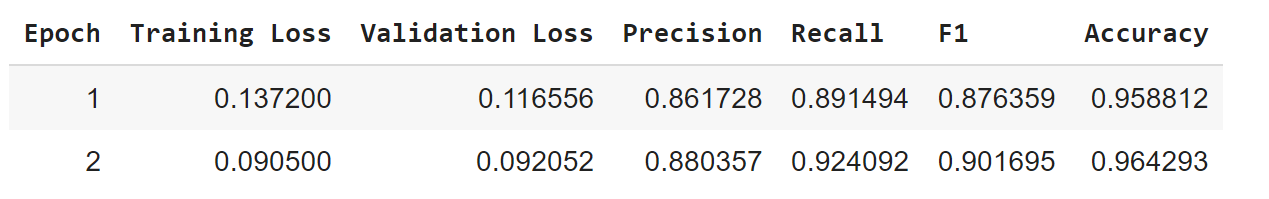